# GeostatsPy Interpolation

For the fourth installment of interpolating between points in Python I am going to use [GeostatsPy](https://github.com/GeostatsGuy/GeostatsPy) to Krige the soil geochemistry dataset that I have been using for the past 3 weeks. To get `GeostatsPy` set-up for this notebook, you just need to make sure the `kb2d.exe` file in this repository is in the same folder as this notebook. After you have that done, you simply import `GSLIB` and `Geostats` from `geostatspy`. Other packages we are going to use include `geopandas`, `numpy`, `itertools`, `matplotlib`, and `contextily`. A lot of inspiration and code was used from the `GeostatsPy` [GitHub](https://github.com/GeostatsGuy/GeostatsPy/tree/master/examples) page as I learned the package.

In [ ]:
! pip install geostatspy

In [1]:
import geostatspy.GSLIB as GSLIB  # GSLIB utilities
import geostatspy.geostats as geostats  # GSLIB converted to Python
import matplotlib.pyplot as plt  # visualizing
import geopandas as gpd  # reading in spatial data
import numpy as np  # for matrices and building grids
from itertools import product  # for making our grid
import contextily as ctx  # for plotting on a basemap

%matplotlib inline

To begin, we are going to read in the `'geochemistry_subset.shp'` shapefile, then we are going to create two new columns for x and y locations of the data. Next, we set some bounds that we can use later on while plotting (so plots match previous weeks), and then we are going to drop 4 samples that refused to cooperate in our kriging efforts.

In [2]:
data = gpd.read_file("geochemistry_subset.shp")  # read in data
data["x"] = data.geometry.x  # new x column
data["y"] = data.geometry.y  # new y column
xdatalim = (data.x.min() - 8000, data.x.max() + 8000)  # data limits
ydatalim = (data.y.min() - 3000, data.y.max() + 3000)  # data limits
data.drop(
    index=[3, 16], inplace=True
)  # get rid of uncooperative data

Then just like we did last week and the week before, we are going to build a grid for our x and y values and reshape it into a 50x50 matrix.

In [3]:
x_values = np.linspace(data.x.min(), data.x.max(), num=50)
y_values = np.linspace(data.y.min(), data.y.max(), num=50)
xy = np.array(list(product(x_values, y_values)))
X0, X1 = xy[:, 0].reshape(50, 50), xy[:, 1].reshape(50, 50)

With our grid in place, we are going to start filling in the arguments that `kb2d` takes by assigning numbers to variables

In [4]:
nx = len(x_values)  # number of x cells
ny = len(y_values)  # number of y cells
xsiz = (
    np.ceil(abs(x_values[0] - x_values[1])) - 33
)  # size of the x cell in meters
ysiz = (
    np.ceil(abs(y_values[0] - y_values[1])) - 33
)  # size of the y cell in meters
xmn = data.x.min()  # minimum x value
ymn = data.y.min()  # minimum y value
# nxdis and nydis: the number of discretization points for a block. If both nxdis and nydis are set to 1 then point kriging is performed.
nxdis = 1
nydis = 1
# ndmin and ndmax: the minimum and maximum number of data points to use for kriging a block.
ndmin = 0
ndmax = 10
radius = 80000  # maximum isotropic search radius
ktype = (
    0
)  # if isk0 then simple kriging will be performed with a mean of skmean
skmean = 30
# tmin and tmax: all values strictly less than tmin and greater than or equal to tmax are ignored.
tmin = -999
tmax = 999

We have our arguments set, now lets create a variogram. I came up with the parameters for this variogram by eyeballing what I thought were reasonable parameters. If this were more than just an exploration into methods, modelling the variogram would be more appropriate

In [5]:
vario = GSLIB.make_variogram(
    nug=0.0, nst=1, it1=1, cc1=1.0, azi1=0, hmaj1=60000, hmin1=60000
)
# All I was interested in was the nugget (nug) and the major and minor ranges (hmaj1, hmin1)

With a variogram we then jump straight into kriging with the `kb2d` method. We fill in all the arguments from two cells above and it cranks on the data.

In [6]:
kmap, vmap = geostats.kb2d(
    data,
    "x",
    "y",
    "qvalue",
    tmin,
    tmax,
    nx,
    xmn,
    xsiz,
    ny,
    ymn,
    ysiz,
    nxdis,
    nydis,
    ndmin,
    ndmax,
    radius,
    ktype,
    skmean,
    vario,
)

  Estimated   2500 blocks 
      average   33.07716879493318  variance  73.11247332301332


We have an array with our kriged values `kmap` and an array with our variance values `vmap`, let's use our `contextily` helper function to grab a base map and get ready to plot it up!

In [7]:
# this cell creates a function that grabs the stamen terrain tiles
def add_basemap(
    ax, zoom, url="http://tile.stamen.com/terrain/tileZ/tileX/tileY.png"
):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(
        xmin, ymin, xmax, ymax, zoom=zoom, url=url
    )
    ax.imshow(basemap, extent=extent, interpolation="bilinear")
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

Just like the previous 3 weeks we are plotting up the samples, a basemap, and then the interpolated data. The only distinction is that this week to get the interpolated data aligned with the rest of the data we had to first transpose the array with `kmap.T` and then flip it using `np.flip` along axis 1. After that everything is lined up and ready to plot with our sample data.

(8351109.307194386, 8501400.229325324)

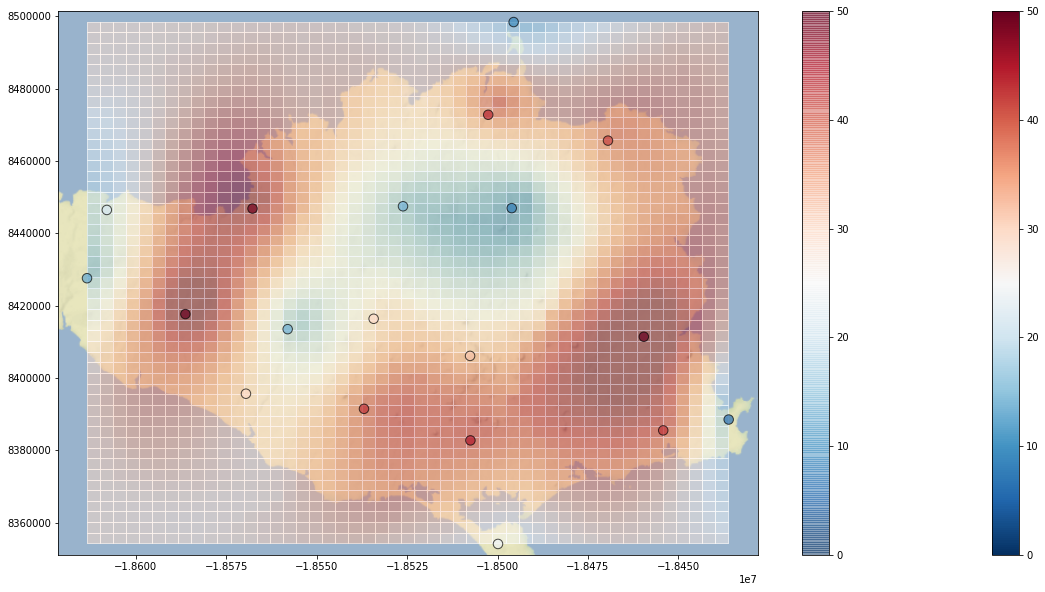

In [8]:
ax = data.plot(
    column="qvalue",
    vmin=0,
    vmax=50,
    figsize=(20, 10),
    legend=True,
    cmap="RdBu_r",
    alpha=0.7,
    edgecolor="k",
    markersize=90,
    zorder=2,
)
ax.set_ylim(ydatalim)
add_basemap(ax, zoom=9)  # add our basemap to the plot

im = plt.pcolormesh(
    X0,
    X1,
    np.flip(kmap.T, axis=1),
    cmap="RdBu_r",
    alpha=0.5,
    zorder=1,
    edgecolor=(1.0, 1.0, 1.0, 1.0),
    linewidth=0.01,
    vmin=0,
    vmax=50,
)
plt.colorbar(im, ax=ax)
plt.xlim(xdatalim)
plt.ylim(ydatalim)

And just like last week, we can plot up the variance data as well!

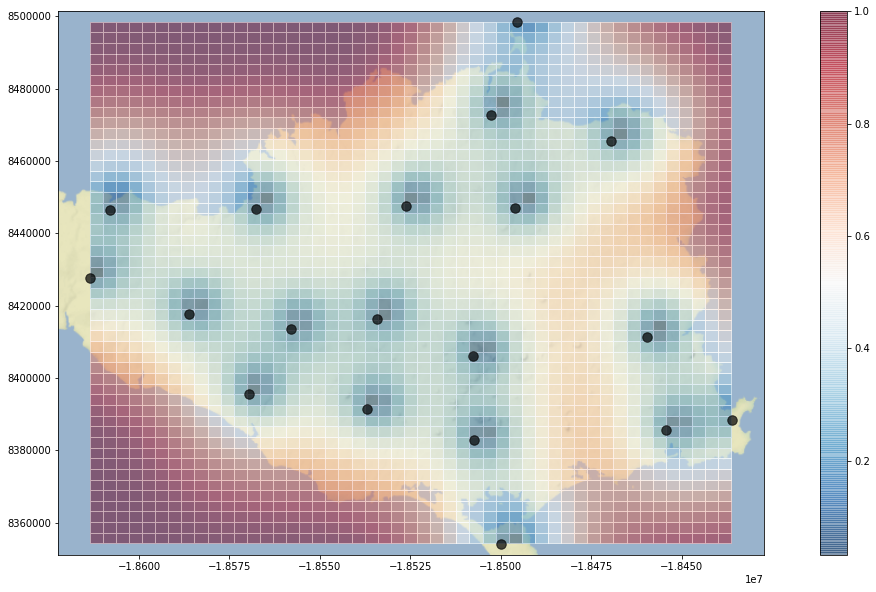

In [9]:
ax = data.plot(
    figsize=(20, 10),
    legend=True,
    color="black",
    alpha=0.7,
    markersize=90,
    zorder=2,
)
ax.set_ylim(ydatalim)

add_basemap(ax, zoom=9)  # add our basemap to the plot
im = ax.pcolormesh(
    X0,
    X1,
    np.flip(vmap.T, axis=1),
    cmap="RdBu_r",
    alpha=0.5,
    zorder=1,
    edgecolor=(1.0, 1.0, 1.0, 1.0),
    linewidth=0.01,
)
plt.colorbar(im, ax=ax)
# plt.xlim(xdatalim)
# plt.ylim(ydatalim)

And there we have it! The last in our 4 week series on interpolating soil geochemistry data.

This notebook is licensed as CC-BY, use and share to your hearts content.